# 🚀 ResNet9 Optimizado - Target 99%+ Accuracy

**Optimizaciones:**
- ResNet9 desde cero (entrena todo)
- tf.data (carga rápida)
- Mixed Precision (GPU turbo)
- One Cycle Learning Rate
- Weight Decay + Gradient Clipping

**Guardado:** Google Drive / Moviles AI99

## 1. 🔗 Configuración Inicial

In [ ]:
from google.colab import drive
import os, json
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Montar Drive
drive.mount('/content/drive')
SAVE_DIR = Path('/content/drive/MyDrive/Moviles AI99')
SAVE_DIR.mkdir(exist_ok=True)

# Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Kaggle
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)
with open('credentials.json', 'r') as cred_file:
    credentials = json.load(cred_file)
with open(kaggle_dir / 'kaggle.json', 'w') as f:
    json.dump({"username": credentials["kaggle_username"], "key": credentials["kaggle_key"]}, f)
os.chmod(kaggle_dir / 'kaggle.json', 0o600)

print(f"✅ Drive: {SAVE_DIR}")
print(f"✅ Mixed Precision: {policy.name}")
print(f"🎮 GPU: {tf.config.list_physical_devices('GPU')}")

Mounted at /content/drive
✅ Drive: /content/drive/MyDrive/Moviles AI99
✅ Mixed Precision: mixed_float16
🎮 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. 📥 Descargar Dataset

In [ ]:
!pip install -q kagglehub
import kagglehub

dataset_path = Path(kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset"))

TRAIN_DIR = VALID_DIR = None
for root, dirs, files in os.walk(dataset_path):
    p = Path(root)
    if p.name == 'train' and len([d for d in p.iterdir() if d.is_dir()]) > 10:
        TRAIN_DIR = str(p)
    elif p.name == 'valid' and len([d for d in p.iterdir() if d.is_dir()]) > 10:
        VALID_DIR = str(p)

print(f"✅ Train: {TRAIN_DIR}")
print(f"✅ Valid: {VALID_DIR}")

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
✅ Train: /kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train
✅ Valid: /kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid


## 3. ⚙️ Configuración

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32  # Más pequeño para más actualizaciones
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

class_names = sorted([d.name for d in Path(TRAIN_DIR).iterdir() if d.is_dir()])
NUM_CLASSES = len(class_names)

print(f"📐 {IMG_SIZE}x{IMG_SIZE} | Batch: {BATCH_SIZE} | Épocas: {EPOCHS}")
print(f"📊 {NUM_CLASSES} clases")

📐 256x256 | Batch: 32 | Épocas: 15
📊 38 clases


## 4. 📊 Crear Dataset con tf.data

In [ ]:
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img, label

def create_dataset(data_dir, augment_data=False):
    file_paths, labels = [], []
    for idx, class_name in enumerate(class_names):
        for img_path in (Path(data_dir) / class_name).glob('*'):
            file_paths.append(str(img_path))
            labels.append(idx)

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.shuffle(len(file_paths)) if augment_data else ds
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds, len(file_paths)

print("⏳ Creando datasets...")
train_ds, train_count = create_dataset(TRAIN_DIR, augment_data=True)
valid_ds, valid_count = create_dataset(VALID_DIR, augment_data=False)
print(f"✅ {train_count} train / {valid_count} valid")

⏳ Creando datasets...
✅ 70295 train / 17572 valid


## 5. 🧠 Crear Modelo ResNet9

In [ ]:
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Add, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def conv_block(x, filters, pool=False):
    x = Conv2D(filters, 3, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    if pool:
        x = MaxPooling2D(4)(x)
    return x

def res_block(x, filters):
    res = conv_block(x, filters)
    res = conv_block(res, filters)
    return Add()([x, res])

# ResNet9 Architecture
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = conv_block(inputs, 64)
x = conv_block(x, 128, pool=True)
x = res_block(x, 128)

x = conv_block(x, 256, pool=True)
x = conv_block(x, 512, pool=True)
x = res_block(x, 512)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# float32 para estabilidad con Mixed Precision
outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = Model(inputs, outputs)
print(f"✅ Modelo ResNet9: {model.count_params():,} params")
model.summary()

✅ Modelo ResNet9: 6,594,214 params


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    147,584 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 6,594,214 (25.15 MB)

 Trainable params: 6,589,734 (25.14 MB)

 Non-trainable params: 4,480 (17.50 KB)

## 6. 📈 One Cycle Learning Rate Scheduler

In [ ]:
import math

steps_per_epoch = train_count // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS

# One Cycle LR: sube 30%, baja 70%
class OneCycleLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr=0.01, total_steps=1000, pct_start=0.3):
        self.max_lr = max_lr
        self.min_lr = max_lr / 25
        self.final_lr = max_lr / 10000
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.step_up = int(total_steps * pct_start)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Fase 1: Subir (0 to step_up)
        lr_up = self.min_lr + (self.max_lr - self.min_lr) * (step / self.step_up)

        # Fase 2: Bajar (step_up to total_steps)
        progress = (step - self.step_up) / (self.total_steps - self.step_up)
        lr_down = self.max_lr - (self.max_lr - self.final_lr) * progress

        return tf.where(step < self.step_up, lr_up, lr_down)

    def get_config(self):
        return {"max_lr": self.max_lr, "total_steps": self.total_steps}

lr_schedule = OneCycleLR(max_lr=0.01, total_steps=total_steps)
print(f"✅ One Cycle LR configurado: {total_steps} steps totales")

✅ One Cycle LR configurado: 32940 steps totales


## 7. ⚡ Compilar Modelo

In [ ]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4,
    clipnorm=0.1  # Gradient Clipping
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Modelo compilado con AdamW + One Cycle LR + Gradient Clipping")

✅ Modelo compilado con AdamW + One Cycle LR + Gradient Clipping


## 8. 🚀 Entrenar

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        str(SAVE_DIR/'mejor_modelo_resnet9.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("🚀 Entrenando ResNet9 con One Cycle LR...")
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)
print("✅ Entrenamiento completado!")

🚀 Entrenando ResNet9 con One Cycle LR...
Epoch 1/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.4428 - loss: 2.5414
Epoch 1: val_accuracy improved from -inf to 0.63943, saving model to /content/drive/MyDrive/Moviles AI99/mejor_modelo_resnet9.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1022s 290ms/step - accuracy: 0.4428 - loss: 2.5411 - val_accuracy: 0.6394 - val_loss: 1.9435
Epoch 2/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7676 - loss: 1.4692
Epoch 2: val_accuracy did not improve from 0.63943
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 326s 148ms/step - accuracy: 0.7676 - loss: 1.4692 - val_accuracy: 0.5889 - val_loss: 2.2621
Epoch 3/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8285 - loss: 1.2109
Epoch 3: val_accuracy did not improve from 0.63943
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 327s 149ms/step - accuracy: 0.8285 - loss: 1.2109 - val_accuracy: 0.4321 - val_loss: 3.2475
Epoch 4/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8431 - loss: 1.

## 9. 💾 Guardar

In [ ]:
model.save(str(SAVE_DIR/'modelo_resnet9_final.keras'))

# Guardar clases
class_indices = {name: i for i, name in enumerate(class_names)}
with open(SAVE_DIR/'clases.json', 'w') as f:
    json.dump(class_indices, f, indent=2)

# Guardar historial
with open(SAVE_DIR/'history.json', 'w') as f:
    json.dump(history.history, f)

print(f"✅ Todo guardado en: {SAVE_DIR}")

✅ Todo guardado en: /content/drive/MyDrive/Moviles AI99


## 10. 📊 Resultados

/tmp/ipython-input-3291913654.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3291913654.py:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3291913654.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(str(SAVE_DIR/'resultados_resnet9.png'), dpi=150)
/tmp/ipython-input-3291913654.py:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(str(SAVE_DIR/'resultados_resnet9.png'), dpi=150)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WIT

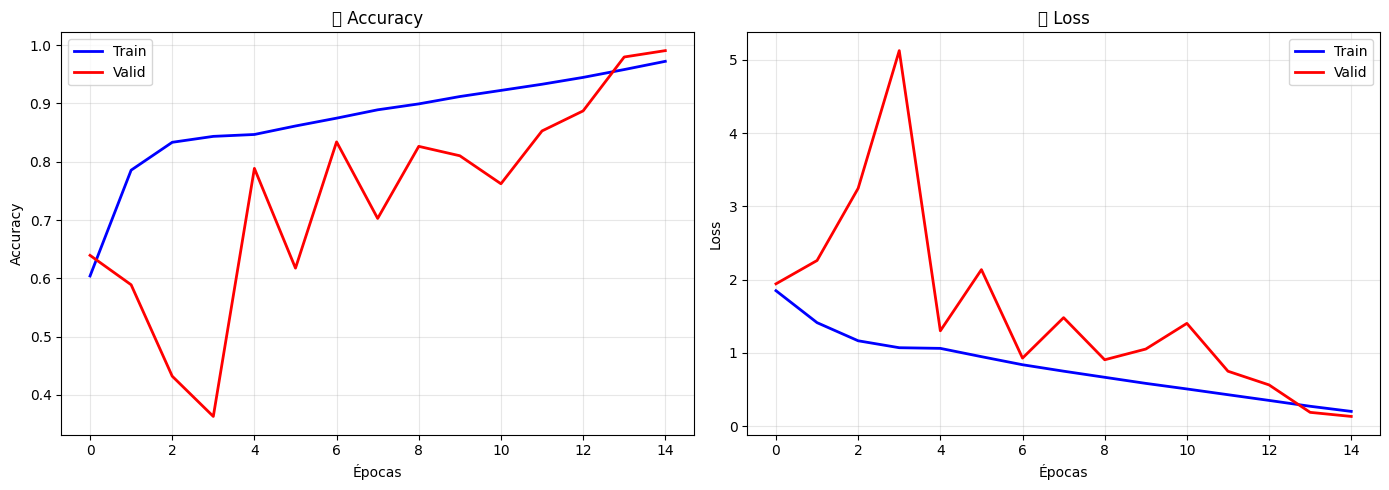


🏆 MEJOR ACCURACY: 99.07%


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], 'r-', label='Valid', linewidth=2)
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Accuracy')
ax1.set_title('📈 Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], 'b-', label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], 'r-', label='Valid', linewidth=2)
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Loss')
ax2.set_title('📉 Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(SAVE_DIR/'resultados_resnet9.png'), dpi=150)
plt.show()

print(f"\n🏆 MEJOR ACCURACY: {max(history.history['val_accuracy']):.2%}")

## 11. 🧪 Evaluar en Validación

In [ ]:
# En lugar de:
# best_model = tf.keras.models.load_model(str(SAVE_DIR/'mejor_modelo_resnet9.keras'))

# Usa esto:
best_model = tf.keras.models.load_model(
    str(SAVE_DIR/'mejor_modelo_resnet9.keras'),
    compile=False  # No cargar el optimizer
)

# Recompilar con optimizer simple
best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Ahora evaluar
loss, acc = best_model.evaluate(valid_ds)
print(f"\n🏆 Accuracy Final: {acc:.2%}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9931 - loss: 0.1260

🏆 Accuracy Final: 99.07%
